In [14]:
''' Retirement calculator using Monte Carlo simulation. '''
# Load imports
import sys
import colorama 
from colorama import Fore
import random
import plotly.express as px
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [15]:
''' Open a data file in percent format and convert to decimal & return a list. '''
# define a function called read_list() to load a data file and process its contents
def read_list(file_name):
    # Open the file using with, which will automatically close it
    with open(file_name) as file:
        # build a list of the contents
        line_var = [float(line.strip()) for line in file]
        # convert the list items from percent to decimal values
        decimal_var = [round(line / 100, 5) for line in line_var]
        # return the decimal list
        return decimal_var

In [16]:
''' Setup default values in input string '''
# define a function called def_input() to get the user input
def def_input(prompt, default=None):
    # prompt & default will be specified when the function is called. Display default value in brackets
    prompt = '{} [{}]: '.format(prompt, default)
    # assigns a response variable to the user input
    response = input(prompt)
    # If nothing entered and a default value exists, the default value is returned; otherwise, the user response is returned
    if not response and default:
        return default
    else:
        return response

In [17]:
''' load data files with original data in percent form. '''
# use the read_list() function to load the six data files
try:
    bonds = read_list('./Resources/10yr_TBond_1928-2021_pct.txt')
    stocks = read_list('./Resources/SP500_returns_1928-2021_pct.txt')
    blend_40_50_10 = read_list('./Resources/SBC_blend_1928-2021_pct.txt')
    blend_50_50 = read_list('./Resources/SB_blend_1928-2021_pct.txt')
    ratio_60_40 = read_list('./Resources/60_40_ratio_1928-2021.txt')
    infl_rate = read_list('./Resources/annual_infl_rate_1928-2021_pct.txt')
# error handling exception
except IOError as e:
    print("{}. \nTerminating program.".format(e), file=sys.stderr)
    sys.exit(1)

In [18]:
# get user input with dictionary for investment types
investment_type = {'bonds': bonds, 'stocks': stocks, '60/40': ratio_60_40,
                        'sb': blend_50_50, 'sbc': blend_40_50_10}

In [19]:
# print header logo
print("\n \n")
print(Fore.RED +"    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(Fore.WHITE +"   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(Fore.BLUE +"  ~~                                                            ,;;   ~~")
print(Fore.BLUE +" ~~   (._.)                                                    (._.)   ~~")
print(Fore.BLUE +"~~    <) )/      R E T I R E M E N T    $ I M U L A T O R      \( (>    ~~")
print(Fore.BLUE +" ~~    / \                                                      / \    ~~")
print(Fore.BLUE +"  ~~  Pablo                                                    Sean   ~~")
print(Fore.WHITE +"   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(Fore.RED +"    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

# print user questions
print(Fore.BLACK +"   How long will your retirement nest egg last?\n   How much could your investments grow?\n   Answer a few questions to see a long-term projection.\n   Then try making a few changes to view the impact on your results.\n\n")

# print input legend for user
print("      How are your savings allocated?\n")
print("      Stocks = S&P 500")
print("      Bonds = 10 year Treasury Bond")
print("      60/40 = 60% S&P 500 / 40% Treasury Bond")
print("      SB Blend = 50% S&P 500 / 50% Treasury Bond")
print("      SBC Blend = 40% S&P 500 / 50% Treasury Bond / 10% Cash \n")
print("      Press ENTER to accept default value shown in [brackets]. \n")



 

   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 ~~   $                                                         $   ~~
~~   $ $       R E T I R E M E N T     S I M U L A T O R       $ $   ~~
 ~~   $                                                         $   ~~
  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

   How long will your retirement nest egg last?
   How much could your investments grow?
   Answer a few questions to see a long-term projection.
   Then try making a few changes to view the impact on your results.


      How are your savings allocated?

      Stocks = S&P 500
      Bonds = 10 year Treasury Bond
      60/40 = 60% S&P 500 / 40% Treasury Bond
      SB Blend = 50% S&P 500 / 50% Treasury Bond
      SBC Blend = 40% S&P 500 / 50% Treasury Bond / 10% Cash 

      Press ENTER to accept de

In [20]:
''' get user input on their investment choice '''
# def_input() function list the names possible choices, which are mapped back to the data lists. lower is used in the event the user enters capital letters
invest_type = def_input("Enter investment type: (stocks, bonds, 60/40, sb,"\
                     " sbc): \n", '60/40').lower()
# error handling, checks input versus the names in the investment_type dict. If input is incorrect, prompt the user for a correct input
while invest_type not in investment_type:
    invest_type = input("Invalid investment. Enter investment type " \
                    "as listed in prompt: ")
# gather input and set default values.
start_value = def_input("Input starting value of investments: \n", \
                             '1500000')
while not start_value.isdigit():
    start_value = input("Invalid input! Input whole numbers only: ")
# gather input and set default values for yearly wityhdrawal.
withdrawal = def_input("How much do you spend each year?" \
                            " (in today's $): \n", '60000')
# error handling, numbers must be integers
while not withdrawal.isdigit():
    withdrawal = input("Invalid input! Input whole numbers only: ")
# gather input and set default values for min years in retirement.
min_years = def_input("Input minimum years in retirement: \n", '18')
# error handling, numbers must be integers
while not min_years.isdigit():
    min_years = input("Invalid input! Input whole numbers only: ")
# gather input and set default values most likely number of years in retirement.
most_likely_years = def_input("Input most-likely years in retirement: \n",
                                  '25')
# error handling, numbers must be integers
while not most_likely_years.isdigit():
    most_likely_years = input("Invalid input! Input whole numbers only: ")
# gather input and set default values max years in retirement.
max_years = def_input("Input maximum years in retirement: \n", '40')
# error handling, numbers must be integers
while not max_years.isdigit():
    max_years = input("Invalid input! Input whole numbers only: ")
# gather input and set default values for MCS sims to run.    
num_cases = def_input("Input number of Monte Carlo Simulations (MCS) to run: \n", '50000')
# error handling, numbers must be integers
while not num_cases.isdigit():
    num_cases = input("Invalid input! Input whole numbers only: ")

''' check for input errors '''
# condition statements to ensure that the min years input is less than the most likely, the most likely is less than the max, and the max does not exceed 100
if not int(min_years) < int(most_likely_years) < int(max_years) \
   or int(max_years) > 100:
    # alert the user, provide user instructions, and exit the program
    print("\nATTENTION: The input years that you entered are not valid.", file=sys.stderr)
    print("\nTIP: Min years need to be less than Most Likey years and less than your Max years.\nAlso, Max years cannot exceed 100. Please Try again!\n \n", file=sys.stderr)
    sys.exit(1)

Enter investment type: (stocks, bonds, 60/40, sb, sbc): 
 [60/40]:  
Input starting value of investments: 
 [1500000]:  
How much do you spend each year? (in today's $): 
 [60000]:  
Input minimum years in retirement: 
 [18]:  
Input most-likely years in retirement: 
 [25]:  
Input maximum years in retirement: 
 [40]:  
Input number of Monte Carlo Simulations (MCS) to run: 
 [50000]:  


In [21]:
''' Run MCS and return investment value at end-of-plan and bankrupt count.'''
# define the montecarlo() function takes returns list as an argument
def montecarlo(returns):
    # start a counter to keep track of which case is being run
    case_count = 0
    # start a counter for the number of cases that run out of money early
    bankrupt_count = 0
    # creates empty list to hold the outcomes of each run
    outcome = []
    # while loop that runs through the cases
    while case_count < int(num_cases):
        # Assigns a new variable to the starting investment value that the user specified
        # converts string values to integers since user input was loaded as strings
        investments = int(start_value)
        # assigns a start_year variable and selects a random value from the range of available years
        start_year = random.randrange(0, len(returns))
        # use triangular() method to draw from a triangular distribution defined by the user’s min_years,
        # most_likely_years, and max_years inputs and returns a random floating-point number 
        duration = int(random.triangular(int(min_years), int(max_years),
                                         int(most_likely_years)))
        # Add duration variable to the start_year variable and assign the result to an end_year variable
        end_year = start_year + duration
        # create lifespan list, that captures all the indexes between the starting year and the ending year
        lifespan = [i for i in range(start_year, end_year)]
        # assigns bankrupt variable to 'no'.
        bankrupt = 'no'

        # build temporary lists for each case to store the returns and inflation data for the chosen lifespan
        lifespan_returns = []
        lifespan_infl = []
        # population lists using lifespan as the index for the returns and inflation lists. 
        for i in lifespan:
            # If the lifespan index is out of range the modulo (%) operator will wrap the indexes
            lifespan_returns.append(returns[i % len(returns)])
            lifespan_infl.append(infl_rate[i % len(infl_rate)])
            
        # loop through each year of retirement for each sim run
        # for loop that will run through all the years in a case
        # uses the index that enumerate() creates to get the yrs average inflation value from the inflation list
        for index, i in enumerate(lifespan_returns):    
            infl = lifespan_infl[index]

            # do not adjust for inflation the first year
            # this conditional statement starts applying inflation after the first year
            if index == 0:
                withdraw_infl_adj = int(withdrawal)
            else:
                withdraw_infl_adj = int(withdraw_infl_adj * (1+infl))
            # Subtract the inflation adjusted withdrawal value from investments variable
            # then adjust investments for the years returns
            investments -= withdraw_infl_adj
            investments = int(investments * (1 + i))
            # Checks value of investments is greater than 0. If it’s not, sets bankrupt variable to 'yes' and ends loop
            if investments <= 0:
                bankrupt = 'yes'
                break
        
        if bankrupt == 'yes':
            # append 0 to the outcome list
            outcome.append(0)
            bankrupt_count += 1
        else:
            # otherwise continue to loop until retirement is reached and append remaining value of investments to outcome
            outcome.append(investments)
        # advance case count by 1 before starting next lifetime sim run   
        case_count += 1
    #  End function by returning the outcome and bankrupt_count variables
    return outcome, bankrupt_count


In [22]:
""" Calculate and determine the chance of running out of money along with other stats. """
# define bankrupt_prob() function that takes the outcome list and bankrupt_count variable returned from the montecarlo()
# function as arguments
def bankrupt_prob(outcome, bankrupt_count):
    # Assigns the length of the outcome list to the total variable
    total = len(outcome)
    # calculates the probability of running out of money as a percentage rounded one decimal place by dividing the
    # number of bankrupt cases by the total number of cases
    odds = round(100 * bankrupt_count / total, 1)
    # displays a summary of the input parameters and results of the simulation
    # sets colors for dramatic effect and enhanced visualizations
    print(Fore.YELLOW + "\n    S U M M A R Y")
    print(Fore.BLACK + "Investment type: {}".format(invest_type))
    print("Starting value: ${:,}".format(int(start_value)))
    print("Annual withdrawal: ${:,}".format(int(withdrawal)))
    print("Years in retirement (min - most likey - max): {}-{}-{}"
          .format(min_years, most_likely_years, max_years))
    print("Number of MCS runs: {:,}\n".format(len(outcome)))
    print(Fore.RED + "Likelihood of you outliving your money: {}%\n".format(odds))
    print(Fore.BLACK + "Average outcome: ${:,}".format(int(sum(outcome) / total)))
    print("Minimum outcome: ${:,}".format(min(i for i in outcome)))
    print("Maximum outcome: ${:,}".format(max(i for i in outcome)))
    # identifies the geniuses behind this simulator
    print(Fore.CYAN +"\nThis retirement simulation was provided to you by:\nHunter, Thomas, Jeff and Ray, aka 'The PHX Mafia'\n\n")
    # ends by returning the odds variable
    return odds



    S U M M A R Y
Investment type: 60/40
Starting value: $1,500,000
Annual withdrawal: $60,000
Years in retirement (min - most likey - max): 18-25-40
Number of MCS runs: 50,000

Likelihood of you outliving your money: 3.2%

Average outcome: $5,733,076
Minimum outcome: $0
Maximum outcome: $45,348,017

This retirement simulation was provided to you by:
Hunter, Thomas, Jeff and Ray, aka 'The PHX Mafia'




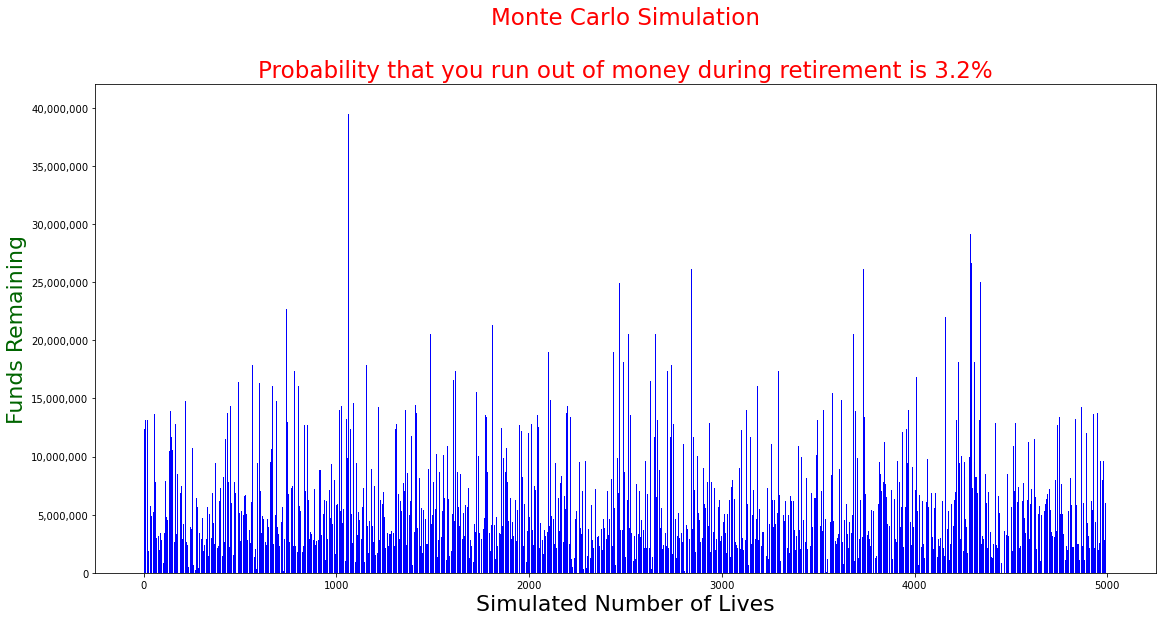

In [23]:
"""Call MCS & bankrupt functions, plot bar chart of MCS sim results. Generate matplotlib bar chart plot first 5000 runs""" 
# define main() function, which requires no arguments
def main():
    # call the montecarlo() function to get the outcome list and the bankrupt_count() function
    outcome, bankrupt_count = montecarlo(investment_type[invest_type])
    # get the odds of running out of money
    odds = bankrupt_prob(outcome, bankrupt_count)  
    # assigns new variable, plotdata, to the first 5,000 items in the outcome list
    plotdata = outcome[:5000]
    # uses matplotlib to create and display the bar chart.
    plt.figure('This retirement simulation was provided to you by, Hunter, Thomas, Jeff and Ray (showing first {} MCS runs)'.format(len(plotdata)),figsize=(19, 9))
    # use list comprehension to build indexes, starting with 1 for year one, based on the length of the plotdata list
    index = [i + 1 for i in range(len(plotdata))]
    # uses bar chart
    plt.bar(index, plotdata, color='blue')
    # x-axis represents the number of lives
    plt.xlabel('Simulated Number of Lives', fontsize=22)
    # y-axis represents the money remaining at the end of each simulated life
    plt.ylabel('Funds Remaining',color='darkgreen', fontsize=22)
    # use scientific notation when it annotates the y-axis
    plt.ticklabel_format(style='scientific', axis='y')
    # get the y-axis and use set_major_formatter() and Func_Formatter() methods and uses lambda function to apply 
    # pyhton's string-formatting technique for comma separators
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}"
                                                         .format(int(x))))
    # displays the plot title and the odds variable with a large font size in eye-catching red
    plt.title('Monte Carlo Simulation\n\nProbability that you run out of money during retirement is {}%'.format(odds),fontsize=23, color='red')
    # draw the plot to the screen
    plt.show()

# run the simulation program
if __name__ == '__main__':
    main()